In [ ]:
using Plots, DelimitedFiles

https://github.com/pitt1321-2161/IndrasNet

In [ ]:
#  "z, ra, dec, bestObjID"
dataz = readdlm("data/0to05final.csv", ',', skipstart = 1)[1:200000,:]
size(dataz) # для рисунка недостаточно памяти, обновите страницу 

In [ ]:
z = dataz[:,1]
ra = dataz[:,2]
dec = dataz[:,3]
# known conversion from redshift to distance from earth
Mly = [3.26*( 3000x - 607.8*x^2 - 156.3*x^3 + 138.3*x^4 )/0.71 for x in z]
# ...ага, известней некуда. 
# Подгоняют походу полином под решения https://arxiv.org/pdf/astro-ph/9905116.pdf
# + https://github.com/Bougeant/Age_of_the_Universe

x_pos = Mly .* cos.( ra*π/180 )
y_pos = Mly .* sin.( ra*π/180 );

In [ ]:
scatter(x_pos, y_pos, m = (1, 0.2, :black), 
    xlab = "Distance, Mly", ylab = "Distance, Mly", size = (800, 600), lab = "", 
   xlim = (-2500, 2500), ylim = (-2500, 2500) );
savefig("SDSS_2500.png")

[источник](https://github.com/jhidding/adhesion-example)

Подробный вывод формул в диссертации Johan Hidding "Adhesion, a sticky way of understanding Large Scale Structure"


Гравитационная неустойчивость
===

Уравнения, управляющие распределением материи во Вселенной, даются законом Ньютона для гравитации. Мы предполагаем, что гравитация является единственной силой, ответственной за формирование структур во Вселенной, и что релятивистские эффекты играют второстепенную роль. Более того, будем считать, что в этом процессе доминирует _темная материя_. Уравнение ньютоновского поля для гравитации - это уравнение Пуассона.

$$\nabla^2 \Phi = 4 \pi G \rho.$$

Однако в расширяющейся Вселенной это уравнение немного меняется на

$$\frac{1}{a^2} \nabla^2 \phi = 4 \pi G \rho_u \delta.$$

Здесь $a$ — коэффициент хаббловского расширения, $\delta$ — возмущение плотности

$$\delta + 1 = \frac{\rho}{\rho_u},$$

и $\phi$ — потенциальное возмущение. Точно так же уравнение Эйлера, описывающее второй закон Ньютона, можно записать в лагранжевой форме как

$$\partial_t(a \vec{v}) \big|_{q={\rm cst}} = -\nabla \phi.$$

Определим $v$ как сопутствующую скорость $v := a\dot{x}$. У нас есть два набора координат $q$ и $x$. $q$ — это метка частицы, сообщающая, где она началась в момент времени $t = 0$.
Тогда

$$x = q + \int \frac{v}{a} {\rm d t}.$$

Определим импульс $p := a^2 \dot{x} = a v$ и перепишем коэффициент пропорциональности

$$4 \pi G \rho_u = \frac{3H_0^2 \Omega_0}{2a^3},$$

так что уравнение Пуассона становится

$$a\nabla^2 \phi = \frac{3}{2} \Omega_m H_0^2 \delta,$$

и уравнение Эйлера

$$\dot{p} = - \nabla \phi.$$

К этому мы добавляем уравнение Фридмана, которое описывает эволюцию коэффициента расширения

$$\dot{a} = H_0 a \sqrt{\Omega_{\Lambda} + \Omega_{m} a^{-3} + (1 - \Omega) a^{-2}}.$$

Обратите внимание, что вся временная зависимость в этих уравнениях находится в разложении $a(t)$, поэтому мы можем выразить все производные по времени через $a$.

$$\dot{x} = \frac{p}{a^2}\quad \to \quad \partial_a x = \frac{p}{a^2 \dot{a}}$$
$$\dot{p} = -\nabla \phi \quad \to \quad \partial_a p = - \frac{\nabla \phi}{\dot{a}}$$

Это означает, что нам не нужно явно решать уравнение Фридмана. Вместо этого мы используем $a$ в качестве переменной интегрирования и используем уравнение Фридмана для определения соответствующей производной $\dot{a}$.

### Вычисление потенциала

Для вычисления потенциала используем интегрирование Фурье уравнения Пуассона:
$$-k^2 \hat{\Phi}(k) = \hat{\delta}_0(k)$$

Начальные условия
===

In [71]:
mutable struct Box
    N::Int64
    L::Float64
    res::Float64
    shape::Tuple{Int64, Int64}
    K::Array{Array{Float64, 2}, 1}
    k_max::Float64
    k_min::Float64
    Box(N,L) = new(N, L, L/N, (N,N), wave_number( (N,N) ) * 2π / L, N*π/L, 2π/L)
end

In [72]:
using FFTW

function wave_number(s)
    N = s[1]
    I = CartesianIndices(s)
    [ [ i > N/2 ? i - N : i for i in getindex.(I, j).-1] for j in 1:length(s) ]
end

function Scale(b::Box, sigma)
    """returns discrete scale space filter, take care with units: 
        [res] = Mpc / pixel, [k] = 1 / Mpc, [t] = Mpc**2"""
    eᵏ = [ exp.( sigma^2 / b.res^2 * (cos.(k*b.res) .- 1.0) ) for k in b.K ]
    return reduce(.*, eᵏ)
end

function garfield(shape, P, T = 1.0)
    wn = randn(shape)
    f  = real.( ifft(fft(wn) .* sqrt.(P)) )
    #f /= f.std()
    return real.( ifft(fft(f) .* T) )
end

# raise |k| to the <n>-th power safely
K_pow(K, n) = [ k<1e-12 ? 0.0 : k^n for k in K ] 
Power_law(b::Box, n) = K_pow( sum( k-> k.^2, b.K ), n/2 )
Cutoff(b::Box) = [ k <= b.k_max^2 ? 1.0 : 0.0 for k in sum( k-> k.^2, b.K ) ]
Potential(b::Box) = -K_pow( sum( k-> k.^2, b.K ), -1.0 );

In [128]:
B_m = Box(128, 16π)
B_m.res

0.39269908169872414

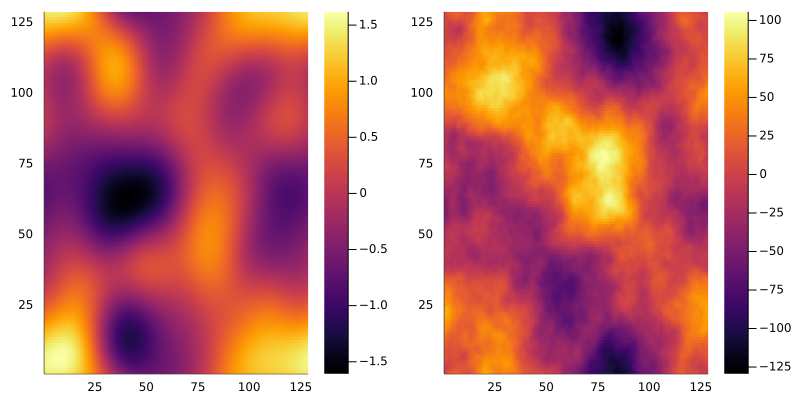

In [129]:
A = 40

Power_spectrum = Power_law(B_m,0) .* Scale(B_m, 0.0) .* Cutoff(B_m)
phi = garfield(B_m.shape, Power_spectrum, Potential(B_m) ) * A
rho = garfield(B_m.shape, Power_spectrum, Scale(B_m, 5.0) ) * A;

p1 = heatmap(rho)
p2 = heatmap(phi)
plot(p1, p2, size = (800, 400))

Космология
===

Фоновая космология воплощена уравнением Фридмана

$$\dot{a} = H_0 a \sqrt{\Omega_{\Lambda} + \Omega_{m} a^{-3} + (1 - \Omega) a^{-2}}.$$

$$D(t) = H(t) \int_0^t \frac{{\rm d} t'}{a(t')^2 H(t')^2}$$

Мы хотели бы выполнить интегрирование с точки зрения $a$, заменив ${\rm d}t = {\rm d}a/\dot{a}$.

$$D(a) = \frac{\dot{a}}{a} \int_0^a \frac{{\rm d}a}{\dot{a}^3}$$

In [75]:
mutable struct Cosmology
    H0::Float64
    OmegaM::Float64 # Matter
    OmegaL::Float64 # Lambda
    OmegaK::Float64 # Kurvatur
    grav_cst::Float64
    
    Cosmology(H0, OmegaM, OmegaL) = 
        new( H0, OmegaM, OmegaL, 1 - OmegaM - OmegaL, 1.5OmegaM*H0^2 )
end

In [76]:
using QuadGK

https://github.com/JuliaMath/QuadGK.jl

In [77]:
adot(c::Cosmology, a) = c.H0 * a * sqrt(c.OmegaL + c.OmegaM * a^-3 + c.OmegaK * a^-2)

growing_mode_norm(c::Cosmology) = 
        0.99999 / ( adot(c, 1) * quadgk(b-> adot(c,b)^-3, 0.00001, 1, rtol=1e-8)[1] );

In [78]:
LCDM = Cosmology(68.0, 0.31, 0.69)
EdS = Cosmology(70.0, 1.0, 0.0) # Einstein–de Sitter
LCDM.grav_cst, EdS.grav_cst

(2150.16, 7350.0)

In [79]:
growing_mode_norm(LCDM), growing_mode_norm(EdS)

(4565.554013574876, 12249.87750042937)

Этот подход работает только в том случае, если Вселенная продолжает расширяться.

Осаждение массы
===

Надлежащее осаждение массы - это своего рода темное искусство. Самая простая и широко используемая схема называется [облако в ячейке](https://www.gnu.org/software/archimedes/manual/html/node29.html).
Частица представляет собой сгусток материи (облако) размером с пиксель. Затем это вещество делится на четыре соседних пикселя, принимая дробное положение внутри текущего пикселя (ячейки). Это можно реализовать с помощью функции `Hist2D`.

https://github.com/Moelf/FHist.jl

In [80]:
using FHist, StatsBase

In [ ]:
# example histogram
x = [1.17803832,  1.30422378,  0.12679263,  0.51118415,  
    0.76266763, 2.16578471,  0.53227499,  2.11799099,  1.53118484,  1.11677877]
y = [0.9843165 ,  1.92549925,  1.91047178,  0.27670436, 
    -0.96415279, -1.18222344, -0.17566342,  2.25929379,  1.85042039, -0.29476961]
xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6];

In [ ]:
h = Hist2D( (x, y), (xedges, yedges) )

In [ ]:
bincounts(h)

In [ ]:
Hist2D((x,y), weights(x.+1), (0:2,0:2))
#nbins(h2)

In [81]:
function Interp2D(data, x, shape)
    "Reasonably fast bilinear interpolation routine"

    X1 = mod.(floor.(Int, x), shape) .+ 1
    X2 = mod.(ceil.(Int,x), shape)   .+ 1
    xm = mod.(x, 1)
    xn = 1.0 .- xm
    
    f1 = [ data[i,j] for (i,j) in zip(X1[:,1], X1[:,2]) ]
    f2 = [ data[i,j] for (i,j) in zip(X2[:,1], X1[:,2]) ]
    f3 = [ data[i,j] for (i,j) in zip(X1[:,1], X2[:,2]) ]
    f4 = [ data[i,j] for (i,j) in zip(X2[:,1], X2[:,2]) ]

    return  f1 .* xn[:,1] .* xn[:,2] + 
            f2 .* xm[:,1] .* xn[:,2] + 
            f3 .* xn[:,1] .* xm[:,2] + 
            f4 .* xm[:,1] .* xm[:,2]
end

gradient_2nd_order(F, i) = 
    ( circshift(F, [(0, 2), ( 2,0)][i] ) - circshift(F, [(0,-2), (-2,0)][i] ) ) / 12.0 + 
    ( circshift(F, [(0,-1), (-1,0)][i] ) - circshift(F, [(0, 1), ( 1,0)][i] ) )* 2.0/3.0

a2r(N, X) = permutedims( reshape( permutedims(X, (3,2,1)), (2, N^2) ) );

In [82]:
function md_cic(X, N)
    rho = zeros(N, N)
    f  = X - floor.(X)
    rng = (0:N, 0:N)

    dats = [ ( mod.(X[:,1]   , N), mod.(X[:,2]   , N) ),
             ( mod.(X[:,1].+1, N), mod.(X[:,2]   , N) ),
             ( mod.(X[:,1]   , N), mod.(X[:,2].+1, N) ),
             ( mod.(X[:,1].+1, N), mod.(X[:,2].+1, N) ) ]
    
    ws = [ weights( (1 .- f[:,1]).*(1 .- f[:,2]) ),
           weights(       f[:,1] .*(1 .- f[:,2]) ),
           weights( (1 .- f[:,1]).*      f[:,2]  ),
           weights(       f[:,1] .*      f[:,2]  ) ]
    
    for (d, w) in zip( dats, ws )
        h = Hist2D( d, w, rng )
        rho += bincounts(h)
    end
    
    return rho
end;

In [83]:
mutable struct Partiklz
    B::Box
    m::Float64
    C::Cosmology
    X::Matrix{Float64}
    P::Matrix{Float64}
    Potencial::Matrix{Float64}
end

### Интегратор

Метод *чехарды* ([leap-frog](https://en.wikipedia.org/wiki/Leapfrog_integration)) для интегрирования дифуров одновременно прост и достаточно точен. У него есть приятное свойство, что интегрирование обратимо. В переводе с языка симплектических интеграторов это означает, что энергия сохраняется.

In [120]:
function Solver(pz::Partiklz, a0, da, N)
    
    function drift(a, da)
        adt = adot(pz.C, a)
        pz.X += da * pz.P / (a^2 * adt)
    end
        
    function kick(a, da)
        adt = adot(pz.C, a)
        x = pz.X / pz.B.res
        delta .= md_cic(x, pz.B.N) * pz.m .+ 1.0
        phi = real.( ifft(fft(delta) .* Potential(pz.B)) ) * pz.C.grav_cst / a
        acc_x = Interp2D(gradient_2nd_order(phi, 2), x, pz.B.N)
        acc_y = Interp2D(gradient_2nd_order(phi, 1), x, pz.B.N)
        acc = [acc_x acc_y] / pz.B.res
        pz.P -= da * acc / adt       
    end

    a = a0
    delta = zeros(pz.B.N, pz.B.N)
    # the kick is half a step ahead
    anim = @animate for i in 1:N
        drift(a, da)
        kick(a+0.5da, da)
        a += da
        heatmap(log.(delta), clim = (0,5), #c = :binary,
            colorbar = false, xticks = false, yticks = false, border = :none )
    end
    #return delta
    return anim
end;

Гравитация
===

Гравитация — это трехмерное явление. Мы верим, что можем использовать те же уравнения в 2D, и результаты будут аналогичны фрагменту из 3D-моделирования. Чтобы сделать все правильно, нам нужно доказать, что это будет идентично моделированию бесконечной стопки копий двумерной вселенной. Сила должна быть пропорциональна $1/r$, а соответствующий потенциал равен $\log(r)$.

Описанному ранее интегратору Leap-frog требуется солвер, чтобы предоставить операторы _drift_ и _kick_. Дрейф просто перемещает частицы на соответствующую величину, следуя $\partial_a x = p/(a^2 \dot{a})$. Скачок немного сложнее. Нужно найти гравитационный потенциал, который ощущает каждая частица, чтобы получить правильное ускорение. С этой целью мы сначала вычисляем $\delta$, используя осаждение массы. Затем мы используем пространство Фурье для вычисления соответствующего потенциала. Градиент этого потенциала оценивается в реальном пространстве с использованием схемы второго порядка и линейной интерполяции для получения приблизительных значений положений частиц.

Чтобы создать хорошие начальные условия из начального потенциала, мы должны использовать приближение Зельдовича. В то же время мы можем использовать эту функцию как фабрику для настройки остальной части моделирования; это означает предоставление решателю правильных размеров коробки и космологии. Интегратору Leap-frog нужна скорость зависящая от иного времени, чем положение частиц (разница в половину временного шага).

Коробок будет две. Одна из них — «массовый ящик», другая — «силовой ящик». Чтобы предотвратить алиасинг в войдах, важно, чтобы силовой ящик был в два раза больше, чем массовый.

In [85]:
function zeldovich(bm, cosmol, phi, a_pos, da, N)
    
    a_vel = a_pos + 0.5da
    bf = Box(bm.N*2, bm.L)
    gg = [gradient_2nd_order(phi, 2) gradient_2nd_order(phi, 1)]
    u = reshape(-gg, (bm.N, bm.N, 2)) / bm.res

    inds = CartesianIndices(bm.shape)
    gg = [getindex.(inds, 1) getindex.(inds, 2)] .- 1
    as = reshape(gg, (bm.N, bm.N, 2)) * bm.res + a_pos * u
    
    m = (bf.N / bm.N)^2 # particle mass. Power from dimension n=2
    x = a2r(bm.N, as)
    p = a2r(bm.N, a_vel .* u)
    
    pz = Partiklz( bf, m, cosmol, x, p, phi )  
    return Solver(pz, a_pos, da, N)
end;

In [132]:
@time anim = zeldovich(B_m, EdS, phi, 0.005, 0.005, 30);

  5.168920 seconds (26.78 M allocations: 2.480 GiB, 8.56% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\User\Downloads\Jupiter Sandbox\New\DarkLivesMatter\cosmic_web128c.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\f5gUd\src\animation.jl:130


Plots.AnimatedGif("C:\\Users\\User\\Downloads\\Jupiter Sandbox\\New\\DarkLivesMatter\\cosmic_web128c.gif")
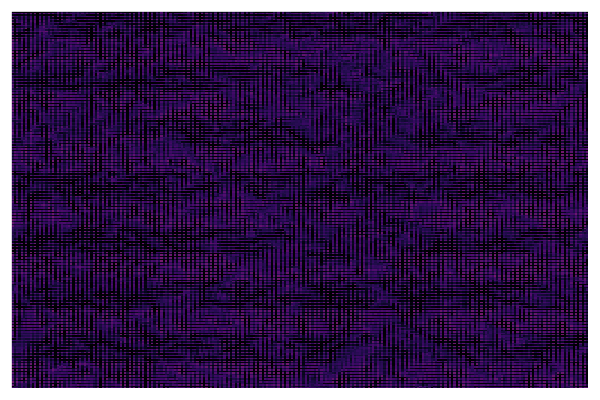

In [133]:
gif(anim, "cosmic_web128c.gif", fps = 8)

In [ ]:
#heatmap( log.(za), colorbar = false, xticks = false, yticks = false )

In [ ]:
#savefig("cosmic_web.png")

# N-body

In [1]:
using Plots, FFTW

In [2]:
function sanitize!(ar)
    """Remove infinities and NaNs from an array"""
    ar[isnan.(ar)] .= 0
    ar[isinf.(ar)] .= 0
end

function apply_powerlaw_power_spectrum(δ, p=-1.0, min_nu=2.0, max_nu=200.0)
    n = size(δ, 1)
    Fδ = fft(δ)
    nu = fftfreq(n)
    nu² = nu.^2
    Nu = sqrt.( nu² .+ nu²' )
    Fδ[Nu.<min_nu/n] .= 0
    Fδ[Nu.>max_nu/n] .= 0
    Nu .^= p
    sanitize!(Nu)
    Fδ .*= Nu
    return real.( ifft(Fδ) )
end

create_linear_field(n) = apply_powerlaw_power_spectrum( randn(n, n) );

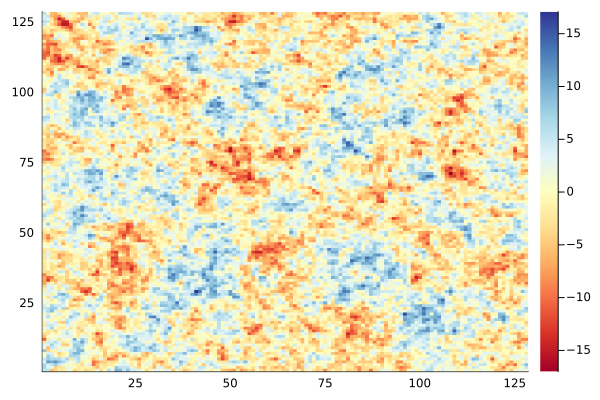

In [28]:
linear_field = create_linear_field(128);
heatmap(linear_field, c = :RdYlBu_11)

In [29]:
savefig("init_cond.png")

In [19]:
function get_potential_gradients(dens_real)
    """Starting from a density field in 2D, get the potential gradients i.e.
    returns the two components of grad"""
    n = size(dens_real, 1)
    dens = fft(dens_real)
    k = fftfreq(n)
    k² = k.^2
    K = -( k² .+ k²' )

    phi = dens ./ K
    sanitize!(phi)

    grad_phi_x = -im*k #.* phi
    grad_phi_y = permutedims(grad_phi_x)
    
    grad_phi_x  = grad_phi_x .* phi
    grad_phi_y  = grad_phi_y .* phi

    grad_phi_x_real = real.( ifft(grad_phi_x) )
    grad_phi_y_real = real.( ifft(grad_phi_y) )

    return grad_phi_x_real, grad_phi_y_real
end;

In [25]:
function get_animation_density(input_linear_field, N = 50, dt=0.001)
    """Starting from a linear field, generate the equivalent non-linear field under the
    Zeldovich approximation at the specified time."""
    n = size(input_linear_field, 1)
    
    x = [0:n-1;] .* ones(1,n)
    y = permutedims(x)
    grad_x, grad_y = get_potential_gradients(input_linear_field)
    
    @animate for i in 1:N
        x += dt*grad_x
        y += dt*grad_y
        x[x.>n] .-= n
        y[y.>n] .-= n
        x[x.<0] .+= n
        y[y.<0] .+= n
        
        scatter(x, y, m = (1, :black), legend = false, 
            xticks = false, yticks = false, border = :none )
    end
end;

In [30]:
@time anim = get_animation_density(linear_field, 10, 4e-3);

  2.760889 seconds (7.46 M allocations: 217.188 MiB, 1.74% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\User\Downloads\Jupiter Sandbox\New\DarkLivesMatter\n_body2.gif
└ @ Plots C:\Users\User\.julia\packages\Plots\yJrrq\src\animation.jl:137


Plots.AnimatedGif("C:\\Users\\User\\Downloads\\Jupiter Sandbox\\New\\DarkLivesMatter\\n_body2.gif")
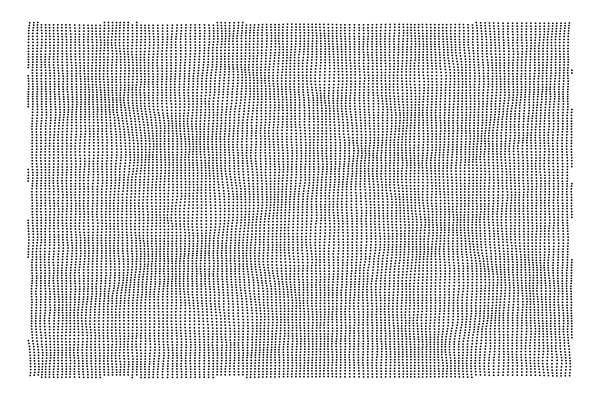

In [31]:
gif(anim, "n_body2.gif", fps = 5)